soy package를 system path에 추가하고, 토크나이징을 위하여 cohesion을 학습할 것인지, 문서들을 토크나이징 할 것인지 미리 지정합니다. 

토크나이징과 같이 작업 시간이 많이 들어갈 수 있는 작업들은 이렇게 맨 위에서 True, False로 설정할 수 있도록 미리 설정해두면, Shift + Enter를 연속으로 누르다가 했던 작업을 다시 하는 실수를 방지할 수 있습니다. 

한 번 토크나이징을 하면, 값을 False로 바꿔두세요. 

In [1]:
import sys
sys.path.append('../soy/')
import soy


TRAIN_COHESION = False
TOKENIZE = False

corpus_fname = '../../../data/sample_naver_movie/merged_comments.txt'
tokenized_corpus_fname = '../../../data/sample_naver_movie/merged_comments_tokenized.txt'
cohesion_fname = '../../../data/sample_naver_movie/navermovie_cohesion'
maxscore_fname = '../../../data/sample_naver_movie/navermovie_maxscore.pkl'


TRAIN_WORD2VEC = False
word2vec_fname = '../../../data/sample_naver_movie/movie_review_word2vec_model.pkl'


TRAIN_DOC2VEC = False
doc2vec_fname = '../../../data/sample_naver_movie/movie_review_doc2vec_model.pkl'

id2movie_fname = '../../../data/sample_naver_movie/navermovie_info_idx2moviename.pkl'
id2actor_fname = '../../../data/sample_naver_movie/navermovie_info_idx2actorname.pkl'

## Preprocessing: Cohesion training + Tokenizing

corpus 파일은 tap으로 구분하여 한 줄에 <영화아이디, 텍스트, 평점>으로 입력되어 있습니다. 

    with open() as f:
        docs=[doc.strip().split('\t') for doc in f]

위 구문은 파일을 읽어 한 줄에 줄바꿈 기호를 제거한 뒤, tap으로 줄을 분리합니다. 그 결과 한 줄에는 [영화아이디, 텍스트, 평점]의 리스트가 들어있게 됩니다. 

    [[영화아이디, 텍스트, 평점], 
     [영화아이디, 텍스트, 평점], 
     ...
    ]

위 형식의 list of list이기 때문에 각각의 column 별로 값을 분리하기 위하여 zip(\*)을 이용합니다. 

In [3]:
def get_text(fname):
    with open(fname, encoding='utf-8') as f:
        docs = [doc.strip().split('\t') for doc in f]
    
    idx, texts, scores = zip(*docs)
    return idx, texts, scores

idx, docs, scores = get_text(corpus_fname)
docs[:5]

('명불허전',
 '왠지 고사 피의중간고사보다 재미가없을듯해요 만약보게된다면실망할듯',
 '티아라 사랑해 ㅜ',
 '황정음 윤시윤 지붕킥 인연 김수로 티아라지연 공부의신 인연 너무너무재미있어요',
 '기대 완전')

문서의 길이는 3,280,685 입니다. 320만개 정도의 리뷰가 있습니다

In [4]:
len(docs)

3280685

TRAIN_COHESION == True이면 cohesion을 학습합니다. 학습된 결과는 data/sample_naver_movie에 navermovie_cohesion 이름으로 저장합니다. 만약 TRAIN_COHESION == False이면 학습된 cohesion을 load합니다

MaxScoreTokenizer에 이용할 scores는 최소 빈도수 10, 최소 cohesion 값 0.001 이상인 단어에 대해서만 filtering 하여 pickle로 저장해둡니다. 

In [15]:
import pickle
from soy.nlp.extractors import CohesionProbability

cohesion = CohesionProbability()

if TRAIN_COHESION:
    cohesion.train(docs)
    cohesion.save(cohesion_fname)
    
    scores = cohesion.get_all_cohesion_probabilities()
    scores = {word:s[0] for word, s in scores.items() if s[2] >= 10 and s[0] > 0.001}
    with open(maxscore_fname, 'wb') as f:
        pickle.dump(scores, f)
        
else:
    cohesion.load(cohesion_fname)
    with open(maxscore_fname, 'rb') as f:
        scores = pickle.load(f)

Cohesion의 L score 기준으로 토크나이징을 수행하는 MaxScoreTokenizer를 만듦니다. 만약 TOKENIZE == True이면 모든 문서들을 토크나이징 합니다. 토크나이징의 예시를 3문장에 대하여 수행하여 그 결과를 미리 살펴봅니다

In [19]:
from soy.nlp.tokenizer import MaxScoreTokenizer

tokenizer = MaxScoreTokenizer(scores=scores)

for doc in docs[:3]:
    print(doc)
    print(tokenizer.tokenize(doc), '\n')

if TOKENIZE:
    with open(tokenized_corpus_fname, 'w', encoding='utf-8') as f:
        for idx_, text, score in zip(idx, docs, scores):
            tokens = ' '.join(tokenizer.tokenize(text)).strip()
            f.write('%s\t%s\t%s\n' % (idx_, tokens, score))
            
    print('tokenizing was done')

명불허전
['명불허전'] 

왠지 고사 피의중간고사보다 재미가없을듯해요 만약보게된다면실망할듯
['왠지', '고사', '피의', '중간', '고사', '보다', '재미', '가', '없을', '듯해요', '만약', '보게', '된다', '면', '실망', '할듯'] 

티아라 사랑해 ㅜ
['티아라', '사랑', '해', 'ㅜ'] 



## Word2Vec 학습

Gensim의 Word2Vec을 학습하기 위해서는 list of str 형식의 input이 필요합니다. 하지만 모든 리뷰들을 메모리에 올리지 않고도 학습할 수 있습니다. generator인 with open을 이용하여 __iter__를 오버라이딩한 CommentWord2Vec이라는 클래스를 생성합니다. 

__iter__에서 

    for doc in f:
        movie_idx, text, score = doc.split('\t')
        yield text.split()

을 수행하면, 파일 f로부터 한 줄을 읽어 tap으로 텍스트를 구분한 뒤, 그 텍스트를 띄어쓰기 기준으로 잘라낸 token list가 for loop 안에서 출력됩니다. 

__iter__는 아래 구문이 작동할 수 있도록 해주는 파이썬 내장함수 입니다. 

    for doc in word2vec_corpus:
        print(doc)

토크나이징이 된 리뷰들을 CommentWord2Vec의 fname으로 입력하였기 때문에, 띄어쓰기 만으로 단어열을 yield 할 수 있습니다. 이러한 작업은 반복이 되기 때문에 raw corpus와 tokenized corpus를 구분하여 저장하는 것이 좋습니다. 

In [2]:
import os
    
class CommentWord2Vec:
    
    def __init__(self, fname):
        self.fname = fname
        if not os.path.isfile(fname):
            print('File not found: %s' % fname)
        
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield text.split()
                
                
word2vec_corpus = CommentWord2Vec(tokenized_corpus_fname)

for num_doc, doc in enumerate(word2vec_corpus):
    if num_doc > 5: break
    print(doc)

['명불허전']
['왠지', '고사', '피의', '중간', '고사', '보다', '재미', '가', '없을', '듯해요', '만약', '보게', '된다', '면', '실망', '할듯']
['티아라', '사랑', '해', 'ㅜ']
['황정', '음', '윤시윤', '지붕킥', '인연', '김수', '로', '티아라지연', '공부', '의신', '인연', '너무', '너무', '재미', '있어', '요']
['기대', '완전']
['기대', '지연', '나온다']


Gensim의 Word2Vec을 이용합니다. 미리 만들어둔 word2vec_corpus를 Word2Vec의 argument로 입력합니다. default parameters를 이용하여 Word2Vec을 학습힙니다. 

Word2Vec의 arguments 중에서 중요한 것들은 아래와 같습니다. 

- size: 단어의 임베딩 공간의 크기
- alpha: learning rate
- window: 한 단어의 좌/우의 문맥 크기
- min_count: 모델이 학습할 단어의 최소 출현 빈도수
- max_vocab_size: None이 아닌 숫자를 입력하면 빈도수 기준으로 상위 max_vocab_size 개수만큼의 단어만 학습
- sg: 1이면 skipgram 이용
- negative: negative sampling에서 negative sample의 개수

In [3]:
from gensim.models import Word2Vec
import pickle

if TRAIN_WORD2VEC:
    word2vec_model = Word2Vec(word2vec_corpus)
    with open(word2vec_fname, 'wb') as f:
        pickle.dump(word2vec_model, f)
        
else:
    with open(word2vec_fname, 'rb') as f:
        word2vec_model = pickle.load(f)

학습된 Word2Vec모델의 .most_similar(단어, topn) 함수는 입력된 단어에 대하여 가장 비슷한 topn개의 다른 단어들과 유사도를 출력합니다. 

아래의 에제에서 '영화'와 가장 비슷한 단어는 '애니'이며, 유사도는 0.7270입니다

In [6]:
word2vec_model.most_similar('영화', topn=10)

[('애니', 0.7270158529281616),
 ('애니메이션', 0.6740480661392212),
 ('작품', 0.6374686360359192),
 ('명화', 0.6239856481552124),
 ('드라마', 0.6083831787109375),
 ('수작', 0.5843718647956848),
 ('블록버스터', 0.5830725431442261),
 ('에니메이션', 0.5776616334915161),
 ('여화', 0.5737490653991699),
 ('양화', 0.5575988292694092)]

In [26]:
word2vec_model.most_similar('하정우', topn=10)

[('송강호', 0.919318675994873),
 ('이정재', 0.852825939655304),
 ('공유', 0.8508720993995667),
 ('황정민', 0.8402723073959351),
 ('송광호', 0.8278650641441345),
 ('유아인', 0.8198508024215698),
 ('손현주', 0.8156596422195435),
 ('설경구', 0.8124169111251831),
 ('김명민', 0.8080841302871704),
 ('박신양', 0.8069778680801392)]

In [27]:
word2vec_model.most_similar('1점', topn=10)

[('일점', 0.8898996114730835),
 ('별1개', 0.8513052463531494),
 ('2점', 0.8441988229751587),
 ('별반개', 0.843772828578949),
 ('별한개', 0.8416849374771118),
 ('3점', 0.8179458379745483),
 ('4점', 0.7843236923217773),
 ('5점', 0.782870888710022),
 ('별2개', 0.7643338441848755),
 ('십점', 0.7511963844299316)]

In [28]:
word2vec_model.most_similar('십점', topn=10)

[('백점', 0.8345217704772949),
 ('별5개', 0.7879848480224609),
 ('별다섯개', 0.7785131931304932),
 ('구점', 0.7737853527069092),
 ('1점', 0.7511963844299316),
 ('일점', 0.734034538269043),
 ('만점', 0.7175484895706177),
 ('반점', 0.7165299654006958),
 ('천점', 0.7126907706260681),
 ('별1개', 0.7063093781471252)]

In [29]:
word2vec_model.most_similar('이동진', topn=10)

[('이용철', 0.8919610977172852),
 ('송경원', 0.8612687587738037),
 ('김현수', 0.8551464080810547),
 ('황진미', 0.8520922660827637),
 ('박평식', 0.8049514889717102),
 ('허지웅', 0.8009775280952454),
 ('정시우', 0.7984682321548462),
 ('이주현', 0.7837086915969849),
 ('씨네21', 0.7780917286872864),
 ('한겨레', 0.7684910297393799)]

In [30]:
word2vec_model.most_similar('평론가', topn=10)

[('기자', 0.8722352981567383),
 ('전문가', 0.8690904378890991),
 ('씨네21', 0.8210318088531494),
 ('평론가들', 0.765844464302063),
 ('기자들', 0.7481426000595093),
 ('황진미', 0.7349421977996826),
 ('한겨레', 0.7320604920387268),
 ('이용철', 0.7223106622695923),
 ('일베', 0.7179790735244751),
 ('평론', 0.7114050388336182)]

In [31]:
word2vec_model.most_similar('평론', topn=10)

[('비평', 0.8205782175064087),
 ('비난', 0.7567965984344482),
 ('마녀사냥', 0.7317776083946228),
 ('평가', 0.7311972379684448),
 ('평론가', 0.7114049792289734),
 ('악평', 0.7046335339546204),
 ('헛소리', 0.6922388076782227),
 ('비판', 0.6894634366035461),
 ('평론가들', 0.6862804889678955),
 ('판단', 0.6772139072418213)]

In [32]:
word2vec_model.most_similar('스토리', topn=10)

[('줄거리', 0.8792709112167358),
 ('시나리오', 0.8635469675064087),
 ('내용', 0.7438483238220215),
 ('내러티브', 0.6806436777114868),
 ('소재', 0.6615859270095825),
 ('전개', 0.6538527011871338),
 ('플롯', 0.6399033069610596),
 ('CG', 0.6355487108230591),
 ('영상미', 0.6278510689735413),
 ('네러티브', 0.6154857873916626)]

In [33]:
word2vec_model.most_similar('조연', topn=10)

[('조연들', 0.8378283381462097),
 ('주연', 0.744808554649353),
 ('조연들의', 0.7030118107795715),
 ('단역', 0.6977415084838867),
 ('정재영', 0.5851399302482605),
 ('배역들', 0.5800350904464722),
 ('이성민', 0.5691245794296265),
 ('배역', 0.5679682493209839),
 ('까메오', 0.5582926273345947),
 ('박성웅', 0.5508951544761658)]

In [34]:
word2vec_model.most_similar('배우', topn=10)

[('캐릭터', 0.7202448844909668),
 ('톱스타', 0.693311333656311),
 ('케릭터', 0.6556588411331177),
 ('베우', 0.6484212875366211),
 ('주연', 0.5995330214500427),
 ('주인공', 0.5758554339408875),
 ('연기', 0.5713545083999634),
 ('아이', 0.571211576461792),
 ('조연들', 0.5567048192024231),
 ('꼬맹이', 0.5439891219139099)]

In [50]:
word2vec_model.most_similar('포디', topn=10)

[('4d', 0.8334470987319946),
 ('3디', 0.8216956257820129),
 ('2d', 0.8174580931663513),
 ('4디', 0.8061981201171875),
 ('아이맥스', 0.7934178709983826),
 ('쓰리디', 0.7897979021072388),
 ('4D', 0.7873770594596863),
 ('3d', 0.7830653190612793),
 ('투디', 0.7762783169746399),
 ('imax', 0.7537804841995239)]

In [49]:
word2vec_model.most_similar('영등포', topn=10)

[('용산', 0.9296648502349854),
 ('일산', 0.9021010398864746),
 ('왕십리', 0.8999133110046387),
 ('센텀', 0.8933353424072266),
 ('목동', 0.8897708654403687),
 ('신도림', 0.8873537182807922),
 ('강변', 0.8852328062057495),
 ('신촌', 0.8834091424942017),
 ('상암', 0.8725293278694153),
 ('김포', 0.8637005090713501)]

In [42]:
word2vec_model.most_similar('메가박스', topn=10)

[('롯데', 0.8718061447143555),
 ('영등포', 0.8630311489105225),
 ('왕십리', 0.8520963788032532),
 ('시네마', 0.8413782119750977),
 ('용산', 0.8399519920349121),
 ('신촌', 0.8258014917373657),
 ('일산', 0.8243458271026611),
 ('센텀', 0.8143980503082275),
 ('홍대', 0.8050951361656189),
 ('롯시', 0.8028289675712585)]

In [36]:
word2vec_model.most_similar('ocn', topn=10)

[('OCN', 0.8665090799331665),
 ('아맥', 0.7466250658035278),
 ('특집', 0.7397516965866089),
 ('설특집', 0.736554741859436),
 ('tv', 0.7252987623214722),
 ('민방위', 0.7093151807785034),
 ('설특선', 0.7013320922851562),
 ('케이블', 0.7009643316268921),
 ('설날특집', 0.6997461915016174),
 ('KBS', 0.6992093324661255)]

In [35]:
word2vec_model.most_similar('황정민')

[('김윤석', 0.9154908657073975),
 ('김명민', 0.9021692872047424),
 ('유해진', 0.8866415023803711),
 ('정재영', 0.8833662271499634),
 ('조진웅', 0.877825140953064),
 ('박신양', 0.8620526790618896),
 ('조정석', 0.8590015172958374),
 ('최민식', 0.85504150390625),
 ('송강호', 0.8549157977104187),
 ('유아인', 0.8516969680786133)]

## Doc2Vec 학습

Doc2Vec을 학습하기 위해서는 각각 문서의 label이 저장되어야 합니다. 이를 위하여 TaggedDocument라는 클래스가 이용됩니다. TaggedDocument는 단어들을 words에, 레이블 정보를 tags에 리스트 형태로 입력합니다

In [7]:
import os
import pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


class CommentDoc2Vec:
    
    def __init__(self, fname):
        self.fname = fname
        if not os.path.isfile(fname):
            print('File not found: %s' % fname)
        
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield TaggedDocument(words=text.split(), tags=['MOVIE_%s' % movie_idx])

                
doc2vec_corpus = CommentDoc2Vec(tokenized_corpus_fname)


if TRAIN_DOC2VEC:
    doc2vec_model = Doc2Vec(doc2vec_corpus)
    with open(doc2vec_fname, 'wb') as f:
        pickle.dump(doc2vec_model, f)

else:
    with open(doc2vec_fname, 'rb') as f:
        doc2vec_model = pickle.load(f)

Doc2Vec은 Word2Vec과 동일하게 단어 벡터를 학습하며, 이를 바탕으로 document vector를 학습합니다. 그렇기 때문에 단어 벡터에 의한 유사도는 동일하게 학습됩니다. 

In [9]:
doc2vec_model.infer_vector?

In [8]:
doc2vec_model.most_similar('영화', topn=10)

[('애니', 0.6325808763504028),
 ('작품', 0.6256965398788452),
 ('명화', 0.5957159399986267),
 ('이야기', 0.5752507448196411),
 ('드라마', 0.5624338388442993),
 ('애니메이션', 0.5499187707901001),
 ('블록버스터', 0.5162981748580933),
 ('백미', 0.5081011056900024),
 ('장르', 0.5013960599899292),
 ('양화', 0.492192804813385)]

Doc2Vec model의 .docvecs안에는 document vector와 관련된 정보들이 저장되어 있습니다

In [42]:
len(doc2vec_model.docvecs)

172

Doctags에 들어있는 offset은 document vector의 임베딩 메트릭스의 row id이며, word_count는 각 태그에 해당하는 문서에 단어가 몇 개 있었는지, doc_count는 각 태그에 해당하는 문서가 몇 번 등장하였는지입니다

In [41]:
for idx, doctag in sorted(doc2vec_model.docvecs.doctags.items(), key=lambda x:x[1].offset):
    print(idx, doctag)

MOVIE_72523 Doctag(offset=0, word_count=94513, doc_count=10187)
MOVIE_59845 Doctag(offset=1, word_count=144494, doc_count=13095)
MOVIE_109753 Doctag(offset=2, word_count=202367, doc_count=10361)
MOVIE_45321 Doctag(offset=3, word_count=294482, doc_count=26915)
MOVIE_45290 Doctag(offset=4, word_count=775777, doc_count=48273)
MOVIE_47385 Doctag(offset=5, word_count=412600, doc_count=41653)
MOVIE_78726 Doctag(offset=6, word_count=326349, doc_count=20615)
MOVIE_89218 Doctag(offset=7, word_count=388191, doc_count=20080)
MOVIE_47528 Doctag(offset=8, word_count=139339, doc_count=13397)
MOVIE_75397 Doctag(offset=9, word_count=236332, doc_count=16444)
MOVIE_48246 Doctag(offset=10, word_count=235112, doc_count=21912)
MOVIE_140695 Doctag(offset=11, word_count=318897, doc_count=23998)
MOVIE_72054 Doctag(offset=12, word_count=378347, doc_count=25748)
MOVIE_102817 Doctag(offset=13, word_count=386768, doc_count=26021)
MOVIE_109960 Doctag(offset=14, word_count=256567, doc_count=14302)
MOVIE_123519 Doct

위에서 MOVIE_59845의 offset = 1은 docvec에서의 row id가 1라는 의미입니다. 

리스트 안의 tuple 값의 의미는 (doctag, 유사도) 입니다 

In [10]:
doc2vec_model.docvecs.most_similar('MOVIE_59845')

[('MOVIE_72408', 0.6937278509140015),
 ('MOVIE_42589', 0.6132638454437256),
 ('MOVIE_48246', 0.6109100580215454),
 ('MOVIE_123519', 0.6034465432167053),
 ('MOVIE_65674', 0.6010728478431702),
 ('MOVIE_73344', 0.5951342582702637),
 ('MOVIE_39841', 0.5864832401275635),
 ('MOVIE_62328', 0.5827306509017944),
 ('MOVIE_41450', 0.5788613557815552),
 ('MOVIE_72523', 0.570276141166687)]

Document vector의 row id로도 most_similar를 찾을 수 있습니다. 

In [44]:
doc2vec_model.docvecs.most_similar(1)

[('MOVIE_72408', 0.6937278509140015),
 ('MOVIE_42589', 0.6132639050483704),
 ('MOVIE_48246', 0.6109099984169006),
 ('MOVIE_123519', 0.6034466028213501),
 ('MOVIE_65674', 0.6010727882385254),
 ('MOVIE_73344', 0.5951342582702637),
 ('MOVIE_39841', 0.5864832401275635),
 ('MOVIE_62328', 0.5827306509017944),
 ('MOVIE_41450', 0.5788613557815552),
 ('MOVIE_72523', 0.5702760815620422)]

Dov2Veco.docvecs.doctags는 document vector의 각 row 기준으로 tag 정보가 저장되어 있습니다. 

In [82]:
list(doc2vec_model.docvecs.doctags)[:5]

['MOVIE_76581', 'MOVIE_102272', 'MOVIE_58088', 'MOVIE_65674', 'MOVIE_107924']

In [83]:
list(doc2vec_model.docvecs.doctags.items())[:5]

[('MOVIE_76581', Doctag(offset=65, word_count=198425, doc_count=18676)),
 ('MOVIE_102272', Doctag(offset=84, word_count=580131, doc_count=33614)),
 ('MOVIE_58088', Doctag(offset=157, word_count=92982, doc_count=10861)),
 ('MOVIE_65674', Doctag(offset=42, word_count=225155, doc_count=20488)),
 ('MOVIE_107924', Doctag(offset=124, word_count=328435, doc_count=20794))]

## Doc2Vec 해석하기

In [11]:
import pickle

with open(id2movie_fname, 'rb') as f:
    idx2movie = pickle.load(f)
    
movie2idx = {name:movie_idx for movie_idx, name in idx2movie.items()}

Doc2Vec.docvecs.most_similar에서는 태그로 구분되는 문서들에 대하여 유사한 다른 문서를 찾아줍니다. 

In [13]:
for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(similar)

('MOVIE_96379', 0.7444707155227661)
('MOVIE_92075', 0.5642454028129578)
('MOVIE_129050', 0.5568262338638306)
('MOVIE_45290', 0.5365338921546936)
('MOVIE_130013', 0.5360148549079895)
('MOVIE_66158', 0.5177206993103027)
('MOVIE_39636', 0.5167732238769531)
('MOVIE_118917', 0.5033876895904541)
('MOVIE_137952', 0.4995463192462921)
('MOVIE_100931', 0.4983254075050354)


영화 아이디를 영화 제목으로 바꿔서 해석해봅시다

In [14]:
for doctag in doc2vec_model.docvecs.doctags:
    movie_idx = doctag.split('_')[1]
    name = idx2movie.get(movie_idx, -1)
    print(movie_idx, '\t', name)

51386 	 포화 속으로
126032 	 수어사이드 스쿼드
118917 	 인턴
45290 	 인터스텔라
119430 	 엑스맨: 아포칼립스
119966 	 쎄시봉
52548 	 의형제
129408 	 메이즈 러너: 스코치 트라이얼
47528 	 해리 포터와 죽음의 성물 - 2부
52515 	 인셉션
140695 	 럭키
109778 	 끝까지 간다
67786 	 쥬라기 월드
109960 	 배트맨 대 슈퍼맨: 저스티스의 시작
76016 	 써니
51143 	 과속스캔들
73318 	 시라노; 연애조작단
58018 	 화려한 휴가
75397 	 미스터 고
53034 	 하모니
41450 	 투사부일체
129050 	 뷰티 인사이드
51918 	 뉴 문
120157 	 검은 사제들
83084 	 최종병기 활
89755 	 레미제라블
142803 	 형
68695 	 추격자
44529 	 해바라기
32686 	 센과 치히로의 행방불명
98438 	 어벤져스: 에이지 오브 울트론
115642 	 신비한 동물사전
74315 	 고지전
113344 	 나우 유 씨 미 2
47370 	 그래비티
17421 	 쇼생크 탈출
107924 	 수상한 그녀
48246 	 7광구
102875 	 국제시장
75355 	 퀵
39640 	 하울의 움직이는 성
92075 	 어바웃 타임
62328 	 설국열차
72054 	 다크 나이트 라이즈
44885 	 아이언맨
102824 	 숨바꼭질
99752 	 군도:민란의 시대
99740 	 혹성탈출: 반격의 서막
106850 	 천안함 프로젝트
94187 	 어메이징 스파이더맨 2
93028 	 용의자
47385 	 국가대표
39157 	 미녀는 괴로워
108225 	 역린
65674 	 좋은 놈, 나쁜 놈, 이상한 놈
44913 	 아수라
37886 	 클레멘타인
62586 	 다크 나이트
74866 	 인디펜던스 데이: 리써전스
88426 	 건축학개론
100931 	 겨울왕국
107373 	 신의 한 수
135843 	 귀향
856

영화 리뷰를 기준으로 각 영화를 document vector로 표현하였을 때 라라랜드와 리뷰가 비슷한 영화는 '비긴 어게인', '어바웃 타임' 등입니다

In [ ]:
doc2vec_fnam

In [15]:
def id2name(similar):
    idx = similar[0].split('_')[1]
    return (idx2movie.get(idx, 'unknown'), idx, similar[1])


print('라라랜드\n')

for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(id2name(similar))

라라랜드

('비긴 어게인', '96379', 0.7444707155227661)
('어바웃 타임', '92075', 0.5642454028129578)
('뷰티 인사이드', '129050', 0.5568262338638306)
('인터스텔라', '45290', 0.5365338921546936)
('님아, 그 강을 건너지 마오', '130013', 0.5360148549079895)
('어거스트 러쉬', '66158', 0.5177206993103027)
('지금, 만나러 갑니다', '39636', 0.5167732238769531)
('인턴', '118917', 0.5033876895904541)
('밀정', '137952', 0.4995463192462921)
('겨울왕국', '100931', 0.4983254075050354)


In [63]:
print('관상\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_93728'):
    print(id2name(similar))

관상

('광해, 왕이 된 남자', '83893', 0.7537062764167786)
('신세계', '91031', 0.7222433090209961)
('내가 살인범이다', '78790', 0.7212600708007812)
('도둑들', '78726', 0.71009361743927)
('더 테러 라이브', '99794', 0.7087115049362183)
('설국열차', '62328', 0.7007530927658081)
('의형제', '52548', 0.6972651481628418)
('베를린', '89218', 0.6868836879730225)
('감시자들', '98146', 0.6800079345703125)
('반창꼬', '91045', 0.6719637513160706)


In [64]:
print('광해 왕이된 남자\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_83893'):
    print(id2name(similar))

광해 왕이된 남자

('7번방의 선물', '94775', 0.8323941230773926)
('내가 살인범이다', '78790', 0.8064652681350708)
('신세계', '91031', 0.7924854159355164)
('반창꼬', '91045', 0.7831587791442871)
('국가대표', '47385', 0.7770907878875732)
('과속스캔들', '51143', 0.7756988406181335)
('세븐 데이즈', '60753', 0.7751924991607666)
('써니', '76016', 0.7714511156082153)
('해바라기', '44529', 0.7613867521286011)
('왕의 남자', '39894', 0.7602701187133789)


In [65]:
print('아바타\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_62266'):
    print(id2name(similar))

아바타

('트랜스포머', '61521', 0.8130666017532349)
('인셉션', '52515', 0.8122845888137817)
('어벤져스', '72363', 0.8106138110160828)
('말할 수 없는 비밀', '68555', 0.8089178800582886)
('디스트릭트 9', '64129', 0.8064645528793335)
('다크 나이트', '62586', 0.8013702630996704)
('다크 나이트 라이즈', '72054', 0.7882226705551147)
('아이언맨', '44885', 0.7750635147094727)
('타이타닉', '18847', 0.7719106078147888)
('국가대표', '47385', 0.7680829763412476)


## t-SNE를 이용한 리뷰가 비슷한 영화의 시각화

In [53]:
doc2vec_model.docvecs.doctag_syn0.shape, type(doc2vec_model.docvecs.doctag_syn0)

((172, 300), numpy.ndarray)

In [123]:
index2tag = [doc2vec_model.docvecs.index_to_doctag(i) for i in range(172)]
print(index2tag[:5])

tag2index = {tag:index for index, tag in enumerate(index2tag)}

index2name = [idx2movie.get(tag.split('_')[1], -1) for tag in index2tag]
print(index2name[:5])

['MOVIE_72523', 'MOVIE_59845', 'MOVIE_109753', 'MOVIE_45321', 'MOVIE_45290']
['고사 두 번째 이야기: 교생실습', '박쥐', '해무', '해운대', '인터스텔라']


이전의 문서 시각화 시간에 살펴보았던 TSNE를 이용하여 document vector를 2차원으로 임베딩을 하여 시각화를 수행합니다. 시간이 오래 걸릴 작업은 %%time을 적어 수행 시간을 출력하면 편합니다.

In [121]:
%%time 

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y_tsne = tsne.fit_transform(doc2vec_model.docvecs.doctag_syn0)

y_tsne.shape

CPU times: user 2.65 s, sys: 116 ms, total: 2.77 s
Wall time: 1.77 s


In [124]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

list(matplotlib.font_manager.get_fontconfig_fonts())[:5]

krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

리뷰의 경향이 비슷하다고 확인되었던 '라라랜드', '어바웃타임', '비긴어게인', '뷰티 인사이드' 등은 비슷한 공간에 위치함을 볼 수 있습니다

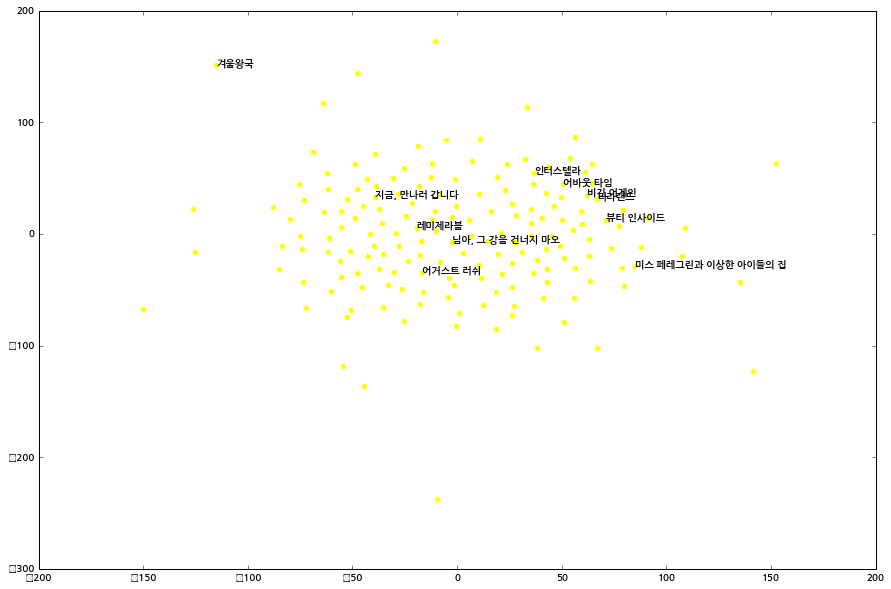

In [139]:
plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_134963')] + ['MOVIE_134963']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()

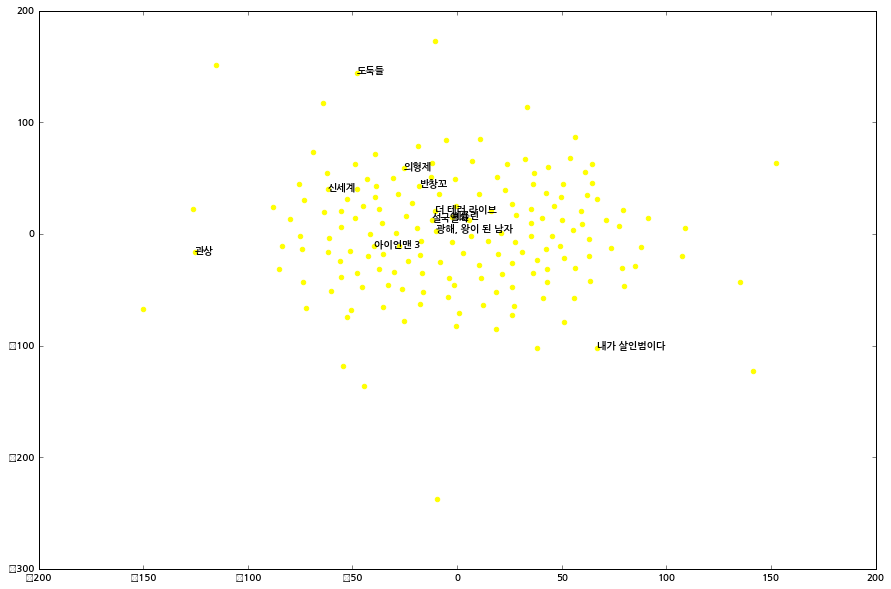

In [140]:
plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_93728')] + ['MOVIE_93728']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()

액션적인 요소가 많았던 영화들은 앞선 라라랜드나 비긴어게인과 같은 영화들과는 떨어져서, 액션 영화들끼리 뭉쳐있음을 확인할 수 있습니다

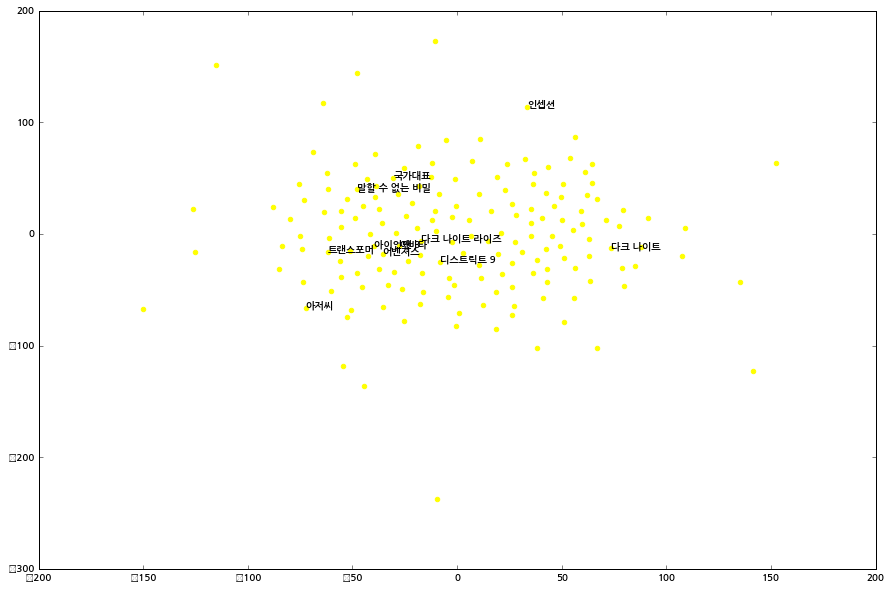

In [141]:
plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_62266')] + ['MOVIE_62266']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()